In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import compute_class_weight
from collections import Counter

import shutil
from sklearn.model_selection import train_test_split


import mlflow
import mlflow.keras

2025-04-13 21:38:01.227081: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 21:38:01.239610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744573081.253049  257167 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744573081.256895  257167 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744573081.270939  257167 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Check for GPU availability and configure memory growth


In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Processing Data


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 20

base_dir ='../data/chest_xray'
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'val')
test_dir = os.path.join(base_dir,'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


<class 'numpy.ndarray'> (224, 224, 1)


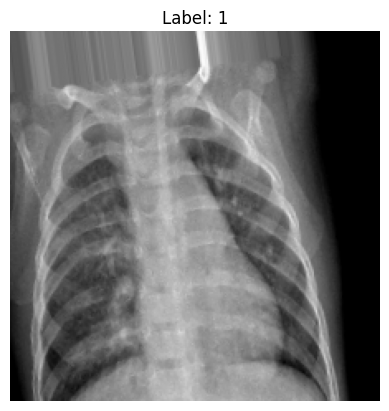

In [4]:
# Function to get a specific image by index
def get_specific_image(generator, index):
    generator.reset()  # Reset the generator to start from the beginning
    images, labels = next(generator)  # Get the first batch

    # Get the specific image and label
    image = images[index]
    label = labels[index]
    print(type(image), image.shape)
    # Display the image
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Label: {int(label)}")
    plt.axis('off')
    plt.show()

# Get and display the image at index 0
get_specific_image(train_generator, 3)

### Count images per class


In [5]:

train_labels = train_generator.classes
print("Train class distribution:", Counter(train_labels))


Train class distribution: Counter({1: 3875, 0: 1341})


In [6]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [8]:


# Create new directories
new_train_dir = os.path.join(project_root,'data/chest_xray_new/train')
new_val_dir = os.path.join(project_root,'data/chest_xray_new/val')
os.makedirs(new_train_dir + '/NORMAL', exist_ok=True)
os.makedirs(new_train_dir + '/PNEUMONIA', exist_ok=True)
os.makedirs(new_val_dir + '/NORMAL', exist_ok=True)
os.makedirs(new_val_dir + '/PNEUMONIA', exist_ok=True)

# Move and split files
for class_name in ['NORMAL', 'PNEUMONIA']:
    files = os.listdir(os.path.join(train_dir, class_name))
    files = [os.path.join(train_dir, class_name, f) for f in files]
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)
    
    # Copy to new directories
    for f in train_files:
        shutil.copy(f, os.path.join(new_train_dir, class_name))
    for f in val_files:
        shutil.copy(f, os.path.join(new_val_dir, class_name))

In [9]:
train_dir = new_train_dir
val_dir = new_val_dir
test_dir = os.path.join(base_dir,'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale'
)

Found 4172 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:

train_labels = train_generator.classes
print("Train class distribution:", Counter(train_labels))

Train class distribution: Counter({1: 3100, 0: 1072})


### Building the Model


In [15]:


INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1)
BATCH_SIZE = 8
EPOCHS = 20 

base_model = MobileNetV2(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = tf.keras.layers.Lambda(lambda x: tf.tile(x,[1,1,1,3]))(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs, name='ChestXray_MobileNetV2_grayscale')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Model: "ChestXray_MobileNetV2_grayscale"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
mlflow.set_experiment("pneumonia_detection_mobilenetv2")

<Experiment: artifact_location='file:///home/metaphysicist/Coding/2025/fh-kiel/Cloud-Computing/Project/scripts/mlruns/573084255572387419', creation_time=1744573168323, experiment_id='573084255572387419', last_update_time=1744573168323, lifecycle_stage='active', name='pneumonia_detection_mobilenetv2', tags={}>

In [13]:
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#     tf.keras.callbacks.ModelCheckpoint('models/best_model.h5',monitor='val_loss',save_best_only=True),
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
# ]

# history =model.fit(
#     train_generator,
#     steps_per_epochs=train_generator.samples // BATCH_SIZE,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // BATCH_SIZE,
#     epochs=EPOCHS,
#     callbacks=callbacks,
#     class_weight=class_weights
# )


TypeError: TensorFlowTrainer.fit() got an unexpected keyword argument 'steps_per_epochs'

### Evaluation


In [ ]:
with mlflow.start_run(run_name="mobilenetv2_run"):
    # Log parameters
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("img_height", IMG_HEIGHT)
    mlflow.log_param("img_width", IMG_WIDTH)
    mlflow.log_param("class_weights", class_weights)

    # Training (existing code, unchanged except within MLflow context)
    class_weights = {0: 1.9448173005219984, 1: 0.6730322580645162}
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('models/best_mobilenetv2.h5', monitor='val_loss', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=callbacks
    )
    print(history.history.keys())
    # Log training metrics
    for epoch, (loss, acc, prec, rec, val_loss, val_acc, val_prec, val_rec) in enumerate(zip(
        history.history['loss'], history.history['accuracy'], history.history['precision'],
        history.history['recall'], history.history['val_loss'], history.history['val_accuracy'],
        history.history['val_precision'], history.history['val_recall']
    )):
        mlflow.log_metric("train_loss", loss, step=epoch)
        mlflow.log_metric("train_accuracy", acc, step=epoch)
        mlflow.log_metric("train_precision", prec, step=epoch)
        mlflow.log_metric("train_recall", rec, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)
        mlflow.log_metric("val_precision", val_prec, step=epoch)
        mlflow.log_metric("val_recall", val_rec, step=epoch)

    # Evaluation
    test_generator.reset()
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
    print(f"MobileNetV2 Evaluation:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

    # Log test metrics
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)

    # Confusion matrix and classification report
    test_generator.reset()
    y_pred = (model.predict(test_generator) > 0.5).astype(int)
    y_true = test_generator.classes
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia'], output_dict=True)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

    # Log confusion matrix as text
    with open("confusion_matrix.txt", "w") as f:
        f.write(str(conf_matrix))
    mlflow.log_artifact("confusion_matrix.txt")

    # Log classification report metrics
    mlflow.log_metric("test_precision_normal", class_report['Normal']['precision'])
    mlflow.log_metric("test_recall_normal", class_report['Normal']['recall'])
    mlflow.log_metric("test_f1_normal", class_report['Normal']['f1-score'])
    mlflow.log_metric("test_precision_pneumonia", class_report['Pneumonia']['precision'])
    mlflow.log_metric("test_recall_pneumonia", class_report['Pneumonia']['recall'])
    mlflow.log_metric("test_f1_pneumonia", class_report['Pneumonia']['f1-score'])

    # Threshold tuning
    y_pred_probs = model.predict(test_generator)
    for t in [0.3, 0.4, 0.5]:
        y_pred_t = (y_pred_probs > t).astype(int)
        class_report_t = classification_report(y_true, y_pred_t, target_names=['Normal', 'Pneumonia'], output_dict=True)
        print(f"\nThreshold {t}:")
        print(classification_report(y_true, y_pred_t, target_names=['Normal', 'Pneumonia']))
        mlflow.log_metric(f"test_precision_pneumonia_threshold_{t}", class_report_t['Pneumonia']['precision'])
        mlflow.log_metric(f"test_recall_pneumonia_threshold_{t}", class_report_t['Pneumonia']['recall'])
        mlflow.log_metric(f"test_f1_pneumonia_threshold_{t}", class_report_t['Pneumonia']['f1-score'])

    # Log model
    mlflow.keras.log_model(model, "mobilenetv2_model")
    mlflow.log_artifact('models/best_mobilenetv2.h5')

Epoch 1/20


I0000 00:00:1744573337.478982  258341 service.cc:152] XLA service 0x7726f0016a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744573337.478999  258341 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2025-04-13 21:42:17.586986: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744573338.225127  258341 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/521 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.5938 - loss: 0.6879 - precision_1: 0.7664 - recall_1: 0.7069   

I0000 00:00:1744573344.672444  258341 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/521 ━━━━━━━━━━━━━━━━━━━━ 1:24 216ms/step - accuracy: 0.8291 - loss: 0.3619 - precision_1: 0.9308 - recall_1: 0.8331

/home/metaphysicist/Coding/2025/fh-kiel/Cloud-Computing/Project/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


521/521 ━━━━━━━━━━━━━━━━━━━━ 49s 76ms/step - accuracy: 0.8727 - loss: 0.2860 - precision_1: 0.9532 - recall_1: 0.8716 - val_accuracy: 0.8669 - val_loss: 0.2968 - val_precision_1: 0.9969 - val_recall_1: 0.8232 - learning_rate: 0.0010
Epoch 2/20
131/521 ━━━━━━━━━━━━━━━━━━━━ 1:22 212ms/step - accuracy: 0.9298 - loss: 0.1733 - precision_1: 0.9804 - recall_1: 0.9231

521/521 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.9282 - loss: 0.1745 - precision_1: 0.9794 - recall_1: 0.9225 - val_accuracy: 0.8918 - val_loss: 0.2399 - val_precision_1: 0.9985 - val_recall_1: 0.8555 - learning_rate: 0.0010
Epoch 3/20
131/521 ━━━━━━━━━━━━━━━━━━━━ 1:17 200ms/step - accuracy: 0.9313 - loss: 0.1641 - precision_1: 0.9789 - recall_1: 0.9269

521/521 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.9352 - loss: 0.1563 - precision_1: 0.9815 - recall_1: 0.9302 - val_accuracy: 0.9100 - val_loss: 0.2085 - val_precision_1: 0.9985 - val_recall_1: 0.8800 - learning_rate: 0.0010
Epoch 4/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.9378 - loss: 0.1540 - precision_1: 0.9832 - recall_1: 0.9324 - val_accuracy: 0.9023 - val_loss: 0.2363 - val_precision_1: 0.9970 - val_recall_1: 0.8710 - learning_rate: 0.0010
Epoch 5/20
131/521 ━━━━━━━━━━━━━━━━━━━━ 1:28 226ms/step - accuracy: 0.9377 - loss: 0.1425 - precision_1: 0.9826 - recall_1: 0.9327

521/521 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.9404 - loss: 0.1375 - precision_1: 0.9830 - recall_1: 0.9360 - val_accuracy: 0.9215 - val_loss: 0.1963 - val_precision_1: 0.9971 - val_recall_1: 0.8968 - learning_rate: 0.0010
Epoch 6/20
131/521 ━━━━━━━━━━━━━━━━━━━━ 1:37 251ms/step - accuracy: 0.9380 - loss: 0.1484 - precision_1: 0.9833 - recall_1: 0.9318

521/521 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - accuracy: 0.9394 - loss: 0.1459 - precision_1: 0.9846 - recall_1: 0.9329 - val_accuracy: 0.9262 - val_loss: 0.1776 - val_precision_1: 0.9943 - val_recall_1: 0.9058 - learning_rate: 0.0010
Epoch 7/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.9465 - loss: 0.1304 - precision_1: 0.9850 - recall_1: 0.9426 - val_accuracy: 0.9195 - val_loss: 0.1906 - val_precision_1: 0.9957 - val_recall_1: 0.8955 - learning_rate: 0.0010
Epoch 8/20
131/521 ━━━━━━━━━━━━━━━━━━━━ 1:29 229ms/step - accuracy: 0.9527 - loss: 0.1357 - precision_1: 0.9897 - recall_1: 0.9458

521/521 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.9540 - loss: 0.1286 - precision_1: 0.9894 - recall_1: 0.9482 - val_accuracy: 0.9377 - val_loss: 0.1527 - val_precision_1: 0.9931 - val_recall_1: 0.9226 - learning_rate: 0.0010
Epoch 9/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.9463 - loss: 0.1327 - precision_1: 0.9842 - recall_1: 0.9424 - val_accuracy: 0.9358 - val_loss: 0.1626 - val_precision_1: 0.9944 - val_recall_1: 0.9187 - learning_rate: 0.0010
Epoch 10/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.9497 - loss: 0.1259 - precision_1: 0.9847 - recall_1: 0.9469 - val_accuracy: 0.9157 - val_loss: 0.2125 - val_precision_1: 0.9985 - val_recall_1: 0.8877 - learning_rate: 0.0010
Epoch 11/20
521/521 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.9569 - loss: 0.1091 - precision_1: 0.9889 - recall_1: 0.9526 - val_accuracy: 0.9195 - val_loss: 0.2130 - val_precision_1: 0.9986 - val_recall_1: 0.8929 - learning_rate: 0.0010
Epoch 12/20
521/521 ━━━━━━━━━━━━━

KeyError: 'precision'